In [33]:
# import libraries

#Load-data Libraries
import pandas as pd
from sqlalchemy import create_engine

#Text Processing libraries
import nltk
nltk.download('stopwords')
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import re

##word embedding
import gensim
import gensim.downloader as gensim_api
import categorical_embedder as ce
from gensim.models import Word2Vec

#Model libraries
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#Save the model
import joblib
from joblib import dump, load

#Evaluate the model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Improve the model
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from nltk.util import ngrams

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/MeriemFerdjouni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/MeriemFerdjouni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/MeriemFerdjouni/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/MeriemFerdjouni/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 1. Retrieve Data

In [2]:
data = pd.read_csv('cleaned_data.csv')

In [3]:
# change the name of columns
data.rename(columns = {'spam': 'Label', 'text':'Email'}, inplace=True)

# 2. NLP: Text Analysis/ Processing 

In [5]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

### Write a tokenization function to process/ clean text data (email)

In [6]:
def tokenize(text):

   #1. Normalize: Convert to lower case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower().strip())
    
   #2. Tokenizing: split text into words
    tokens = word_tokenize(text)
    
   #3. Remove stop words: if a token is a stop word, then remove it
    words = [w for w in tokens if w not in stopwords.words("english")]
    
    #4. Lemmatize and Stemming
    lemmed_words = [WordNetLemmatizer().lemmatize(w) for w in words]
    
    clean_tokens = []
    
    for i in lemmed_words:
        clean_tokens.append(i)
        
        ## back to string from list
    text = " ".join(clean_tokens)
    return text

    #return clean_tokens   

In [11]:
data['Pro_Text'] = data['Email'].apply(lambda x: tokenize(x))
data.head()

,Email,Label,Pro_Text
0,irresistible your corporate identity lt is re...,1,irresistible corporate identity lt really hard...
1,stock trading gunslinger fanny is merrill but...,1,stock trading gunslinger fanny merrill muzo co...
2,unbelievable new homes made easy im wanting t...,1,unbelievable new home made easy im wanting sho...
3,4 color printing special request additional i...,1,4 color printing special request additional in...
4,"do not have money , get software cds from here...",1,money get software cd software compatibility g...


In [34]:
# assign the independent features (text) to X variable and the target to y
X = data['Email']
y = data['Label']

# 3. Split the dataset into Train and Test sets

In [35]:
#split data into training 77% and test 33%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# 4. Train The Pipeline

In [36]:
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())
    ])

In [37]:

#train pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7fed0145f1f0>)),
                ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

# 5. Test the Pipeline

In [38]:
# Predit using the trained model
predicted = pipeline.predict(X_test)

# 6. Evaluate the model

In [44]:
from sklearn.metrics import accuracy_score
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test, predicted)

print("Accuracy:",  round(accuracy,2))

print("Other Metrics:")
print(classification_report(y_test, predicted))
    


Accuracy: 0.74
Other Metrics:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1398
           1       0.00      0.00      0.00       493

    accuracy                           0.74      1891
   macro avg       0.37      0.50      0.43      1891
weighted avg       0.55      0.74      0.63      1891



In [39]:
from sklearn.metrics import confusion_matrix
## Plot confusion matrix
print(confusion_matrix(y_test, predicted))

[[1398    0]
 [ 493    0]]


In [66]:
#
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_curve

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

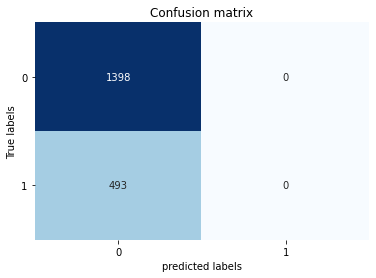

In [67]:
## Plot confusion matrix
classes = np.unique(y_test)

cm = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()

sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="predicted labels", ylabel="True labels", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)



Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.26')

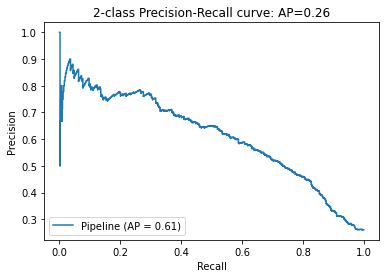

In [77]:
## Plot precision-recall curve
y_test_array = y_test.values
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
average_precision = average_precision_score(y_test, predicted)
disp = plot_precision_recall_curve(pipeline, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))